In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve, learning_curve
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data/telecom_churn.csv').drop('State', axis=1)
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = data['Churn'].astype('int').values
X = data.drop('Churn', axis=1).values

In [6]:
data.head(3)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


## Logistic Regression with SGD

In [7]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17, max_iter=5)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), 
                       ('sgd_logit', sgd_logit)])
val_train, val_test = validation_curve(logit_pipe, X, y,
                                       'sgd_logit__alpha', alphas, cv=5,
                                       scoring='roc_auc')

# Plots (underfitted)

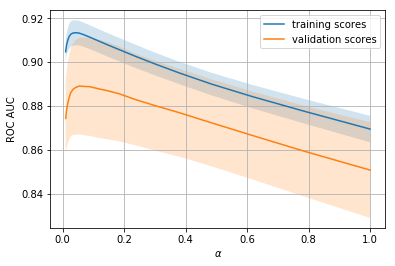

In [12]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True);

In [15]:
def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                           ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha, max_iter=5))])
    N_train, val_train, val_test = learning_curve(logit_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()
    plt.grid(True);

## reduce the regularization coefficient to 0.01

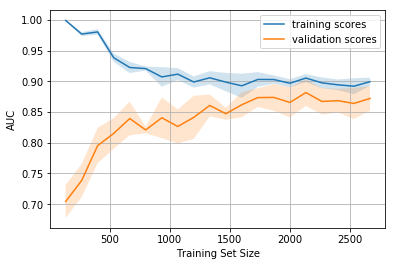

In [21]:
plot_learning_curve(degree=2, alpha=0.01)

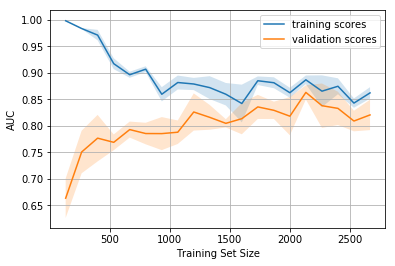

In [22]:
plot_learning_curve(degree=2, alpha=1e-4)


# Conclusions on the learning and validation curves:

* Error on the training set says nothing about the quality of the model by itself
* Cross-validation error shows how well the model fits the data (the existing trend in the data) while retaining the ability to generalize to new data
* Validation curve is a graph showing the results on training and validation sets depending on the complexity of the model:
- * if the two curves are close to each other and both errors are large, it is a sign of underfitting
- *  if the two curves are far from each other, it is a sign of overfitting
* Learning Curve is a graph showing the results on training and validation sets depending on the number of observations:
* if the curves converge, adding new data won't help, and it is necessary to change the complexity of the model
* if the curves have not converged, adding new data can improve the result